In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define hyperparameters
# batch_size = 32 
batch_size = 1 
num_epochs = 10
learning_rate = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Device to use

# Define data transformations
transform = transforms.Compose( 
    [transforms.Resize((64, 64)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

# Load the data
trainset = torchvision.datasets.ImageFolder(root='/Users/newuser/Projects/robust-algo-trader/cnn/train', transform=transform) 
testset = torchvision.datasets.ImageFolder(root='/Users/newuser/Projects/robust-algo-trader/cnn/test', transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# classes = ('won', 'loss')

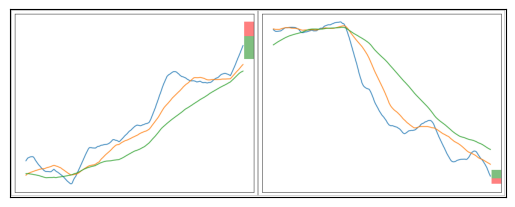

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
        

from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

img1 = read_image(str(Path('/Users/newuser/Projects/robust-algo-trader/cnn/train/0') / '265.png'))
img2 = read_image(str(Path('/Users/newuser/Projects/robust-algo-trader/cnn/test/1') / '25840.png'))

grid = make_grid([img1, img2])
show(grid)

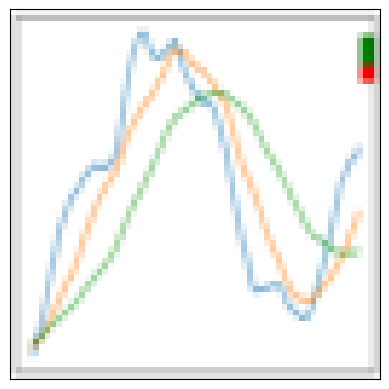

In [32]:
for inputs, labels in train_loader:
    break
inputs = torch.squeeze(inputs)
grid = make_grid([inputs])
show(grid)

In [ ]:

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3) # Input channels, output channels, kernel size
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2) # Kernel size, stride
        # Dropout layer
        self.dropout = nn.Dropout(0.25) # Dropout probability
        # Linear layers
        self.fc1 = nn.Linear(64 * 6 * 6, 128) # Input features, output features
        self.fc2 = nn.Linear(128, 1) # Output features, output features
        # Activation function
        self.sigmoid = nn.Sigmoid() # Sigmoid function for binary classification

    def forward(self, x):
        # Apply the convolutional layers with pooling and dropout
        x = self.pool(self.conv1(x))
        x = self.dropout(x)
        x = self.pool(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(self.conv3(x))
        x = self.dropout(x)
        # Flatten the output of the last convolutional layer
        x = x.view(-1, 64 * 6 * 6)
        # Apply the linear layers with dropout and sigmoid
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Create an instance of the model
model = Net()
# Move the model to the device
model.to(device)

# Define the loss function and the optimizer
criterion = nn.BCELoss() # Binary cross entropy loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # Stochastic gradient descent optimizer

In [ ]:

# Train the model
for epoch in range(num_epochs): # Loop over the dataset multiple times
    running_loss = 0.0 # Initialize the running loss
    for i, data in enumerate(train_loader, 0): # Loop over the batches of data
        # Get the inputs and the labels
        inputs, labels = data
        # Reshape the labels to match the output shape
        labels = labels.view(-1, 1)
        # Move the inputs and the labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute the loss
        loss = criterion(outputs, labels.float())
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199: # Print every 200 batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')


In [ ]:
# Define a function to compute accuracy
def accuracy(outputs, labels):
    # Round the outputs to 0 or 1
    predicted = torch.round(outputs)
    # Count the number of correct predictions
    correct = (predicted == labels).sum().item()
    # Return the percentage of correct predictions
    return 100 * correct / len(labels)



# Save the model
PATH = './model.pth'
torch.save(model.state_dict(), PATH)

# Load the model
model = Net()
model.load_state_dict(torch.load(PATH))
model.to(device)

# Test the model
y_true = [] # True labels
y_score = [] # Predicted scores
y_pred = [] # Predicted labels
with torch.no_grad(): # No need to track the gradients
    for data in test_loader: # Loop over the batches of data
        # Get the inputs and the labels
        inputs, labels = data
        # Reshape the labels to match the output shape
        labels = labels.view(-1, 1)
        # Move the inputs and the labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        # Compute the accuracy
        acc = accuracy(outputs, labels)
        print('Accuracy: %.2f %%' % acc)
        # Append the true labels, predicted scores and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())
        y_pred.extend(torch.round(outputs).cpu().numpy())

# Compute the precision, recall and F1 score
precision = accuracy(np.array(y_true), np.array(y_pred))
recall = accuracy(np.array(y_pred), np.array(y_true))
f1_score = 2 * precision * recall / (precision + recall)
print('Precision: %.2f %%' % precision)
print('Recall: %.2f %%' % recall)
print('F1 score: %.2f %%' % f1_score)

# Plot the ROC curve and compute the AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score) # False positive rate, true positive rate, thresholds
roc_auc = auc(fpr, tpr) # Area under the curve
plt.figure() # Create a new figure
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc) # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # Plot the random guess line
plt.xlim([0.0, 1.0]) # Set the x-axis limit
plt.ylim([0.0, 1.05]) # Set the y-axis limit
plt.xlabel('False Positive Rate') # Set the x-axis label
plt.ylabel('True Positive Rate') # Set the y-axis label
plt.title('Receiver operating characteristic') # Set the title
# plt.legend(loc